# 0.0 Imports

In [1]:
import math
import pickle
import datetime
import inflection

import pandas              as pd
import numpy               as np
import seaborn             as sns
import xgboost             as xgb
import matplotlib.gridspec as gridspec



from matplotlib           import pyplot as plt
from IPython.core.display import HTML
from IPython.display      import Image
from tabulate             import tabulate
from scipy                import stats as ss

## 0.1 Helper Functions

In [2]:
def crammer_v (x, y):
    cm = pd.crosstab(x, y).values
    
    n = cm.sum()
    
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2_correct = max(0, chi2 - (k-1)*(r-1)/(n-1))
    k_correct = k - (k-1)**2/(n-1)
    r_correct = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2_correct/n)/(min(k_correct-1, r_correct-1)))


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

def mean_percentage_error(y, yhat):
    return np.mean((y-yhat)/y)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


def cross_validation(x_training, kfold, model_name, model, verbose=False):
    
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # trainig and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each KFolder iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

## 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)


# ============ merge ============ #

df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

### Notes ###
# merge é uma classe da biblioteca pandas, acessada através do ponto (.).
# how está identificando como esse merge vai acontecer, no caso, é conveniente deixar left, já que a tabela com mais
# informações está na esquerda e a com menos informações está na direita.
# Por fim, on indica a coluna comum entre as duas que será usada para fazer essa junção.



In [46]:
df_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0 PASSO 01 - DESCRIÇÃO DOS DADOS

In [47]:
df1 = df_raw.copy()

In [48]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Renomear Colunas

In [49]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']



snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

### Note ###
# A função map está fazendo um mapeamento da função snakecase em todas as palavras da lista cols_old
# Como retorno temos uma lista que é guardada na variável cols_new

#rename
df1.columns = cols_new

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Dimensão dos dados

In [50]:
print('Number of Rows: {}' .format(df1.shape[0]) )
print('Number of Columns: {}' .format(df1.shape[1]) )

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Datatypes

In [51]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check nos NAs

In [54]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.5 Fillout NA

In [55]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year  
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval               
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [56]:
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

In [57]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [58]:
df1.sample(5).T

,884486,329363,987430,376711,51714
store,1077,497,326,96,425
day_of_week,2,2,7,7,1
date,2013-04-30 00:00:00,2014-09-23 00:00:00,2013-01-27 00:00:00,2014-08-03 00:00:00,2015-06-15 00:00:00
sales,6343,7637,0,0,4995
customers,681,1043,0,0,592
open,1,1,0,0,1
promo,1,0,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,d,a,d


In [59]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [60]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical

In [61]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### NOTE ###
# Separando as variáveis em categóricas e numéricas

### 1.7.1 Numerical atributes

In [62]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\joao\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance'>

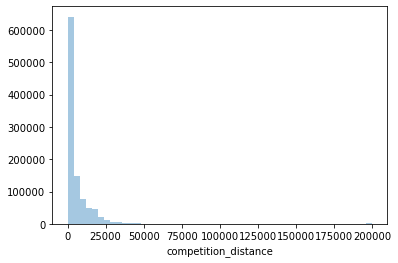

In [63]:
sns.distplot(df1['competition_distance'], kde=False)

### 1.7.2 Categorical atributes

In [64]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

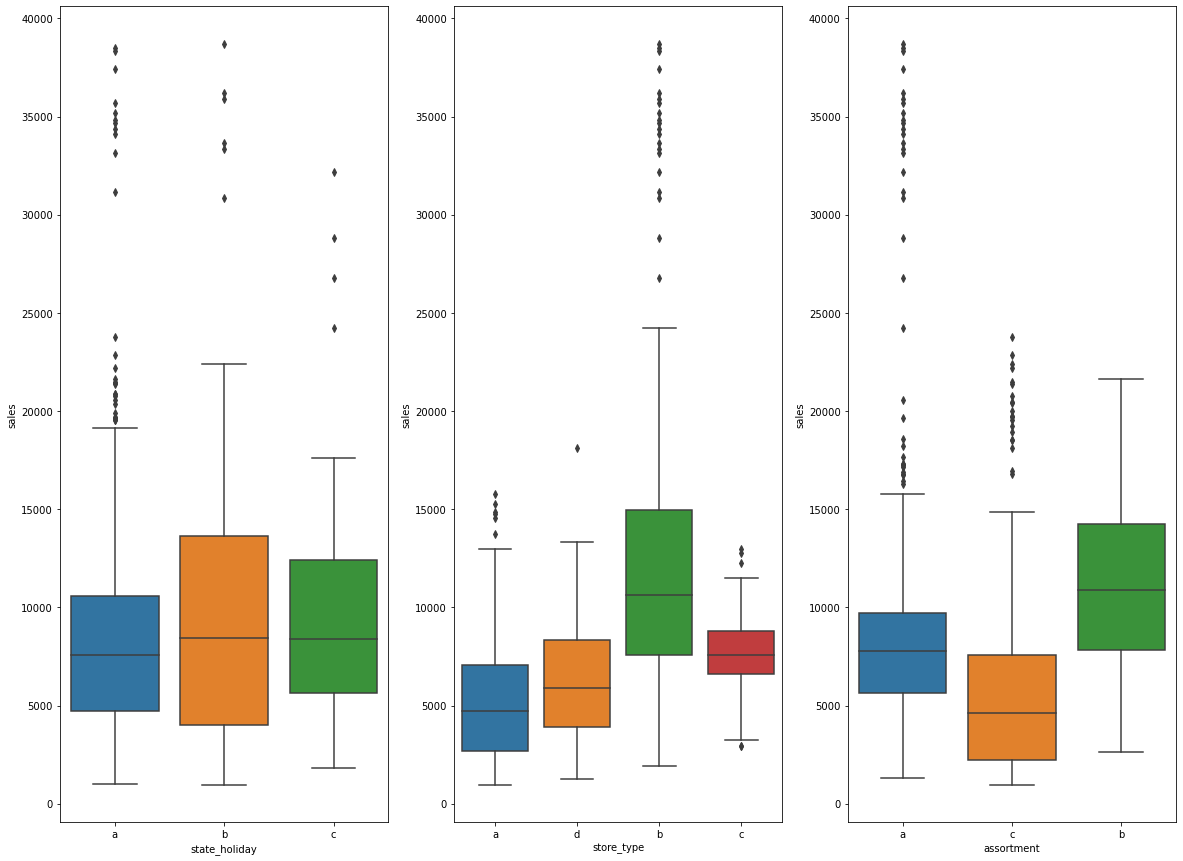

In [66]:
fig, ax = plt.subplots(figsize=(20,15))
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux);

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux);

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux);

# 2.0 PASSO 02 - FEATURE ENGINEERING

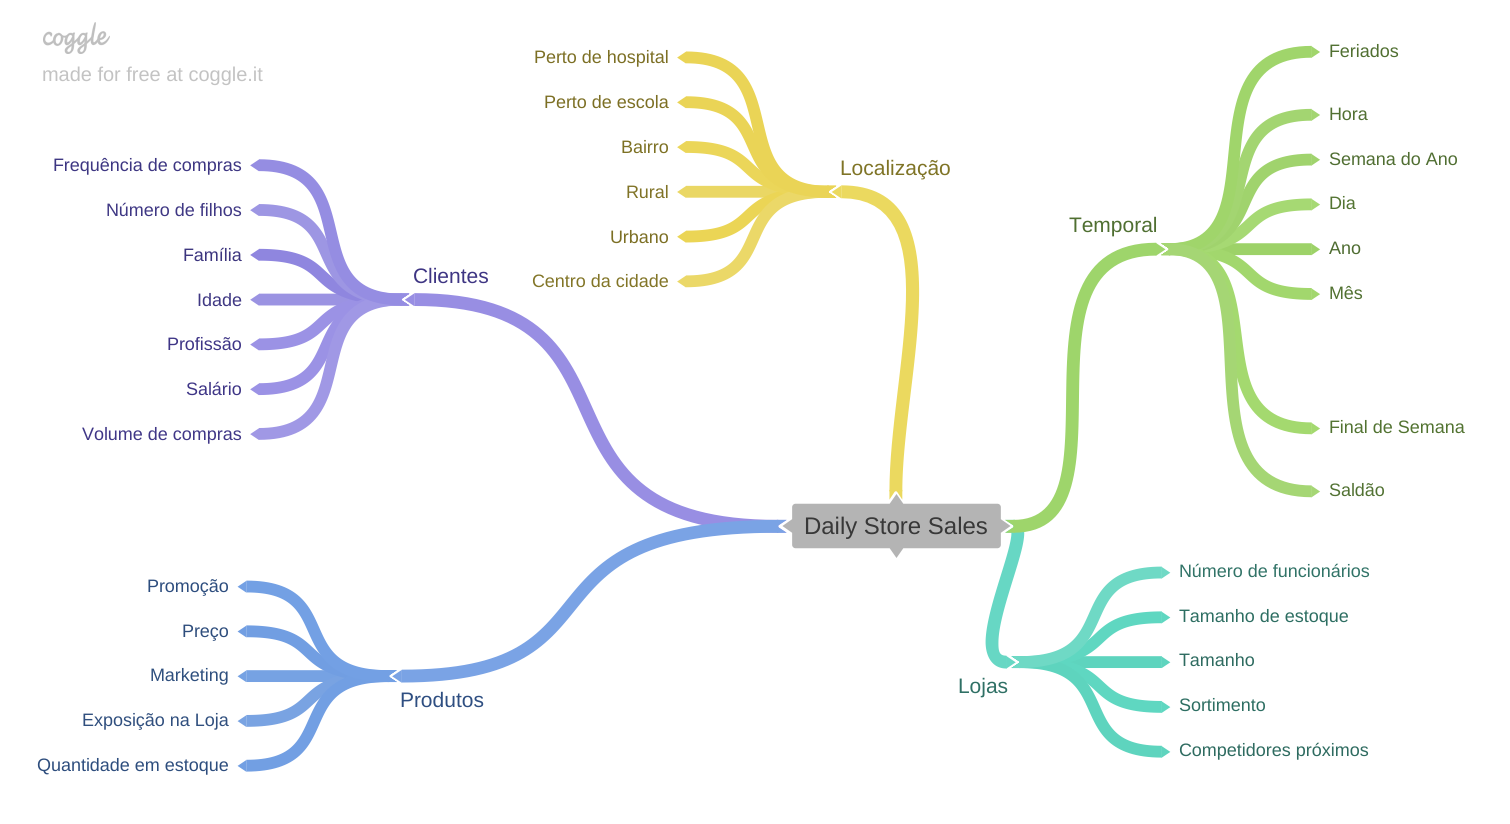

In [67]:
Image('images/Daily_Store_Sales.png')

## 2.1 Criação de Hipóteses

### 2.1.1 Hipóteses Loja

**1** Lojas com maior número de funcionários deveriam vender mais.

**2** Lojas com maior capacidade de estoque deveriam vender mais.

**3** Lojas com maior porte deveriam vender mais.

**4** Lojas com maior sortimento deveriam vender mais.

**5** Lojas com competidores mais próximos deveriam vender menos.

**6** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.1 Hipóteses Produto

**1** Lojas que investem mais em marketing deveriam vender mais.

**2** Lojas com maior exposição de produtos deveriam vender mais.

**3** Lojas com produtos com preço menor deveriam vender mais.

**4** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6** Lojas com mais dias de promoção deveriam vender mais.

**7** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.1 Hipóteses Tempo

**1** Lojas abertas durante o feriado de natal deveriam vender mais.

**2** Lojas deveriam vender mais ao longo dos anos.

**3** Lojas deveriam vender mais no segundo semestre do ano.

**4** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5** Lojas deveriam vender menos aos finais de semana.

**6** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista Final de Hipóteses

## 2.3 Feature Engineering

In [68]:
df2 = df1.copy()

In [69]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


C:\Users\User\AppData\Local\Temp\ipykernel_23176\2367785993.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [70]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [71]:
df3 = df2.copy()

In [72]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das linhas

In [73]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtragem das colunas

In [74]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. PASSO 4 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [76]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response variable

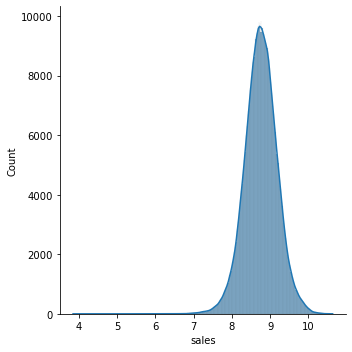

In [77]:
sns.displot(np.log1p(df4['sales']), kde=True)

### 4.1.2 Numerical variable

C:\Users\User\AppData\Local\Temp\ipykernel_23176\46414605.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  num_attributes.hist(bins=25, ax=ax);


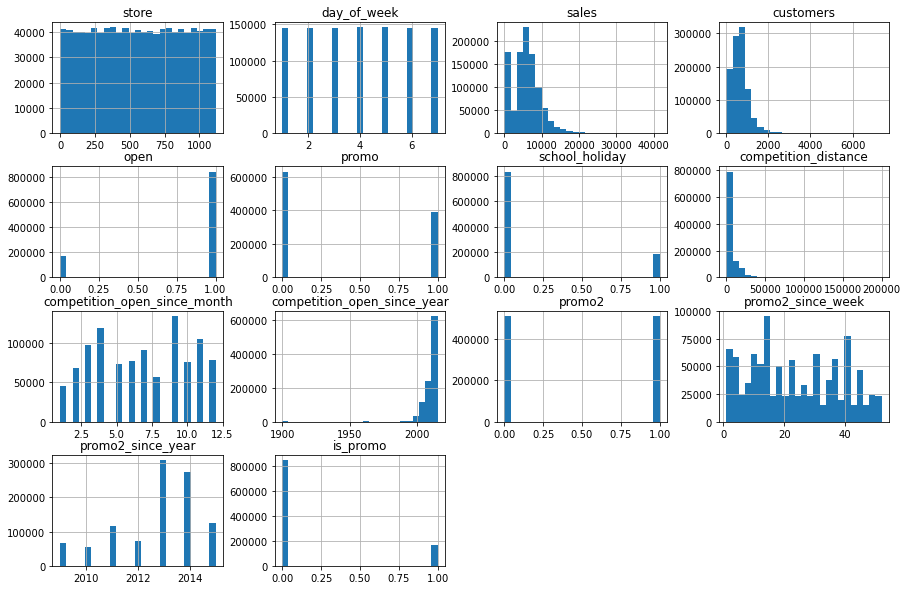

In [78]:
f, ax = plt.subplots(figsize = (15, 10))
num_attributes.hist(bins=25, ax=ax);

### 4.1.3 Categorical variable

In [79]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

C:\Users\joao\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\joao\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\joao\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\joao\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments wit

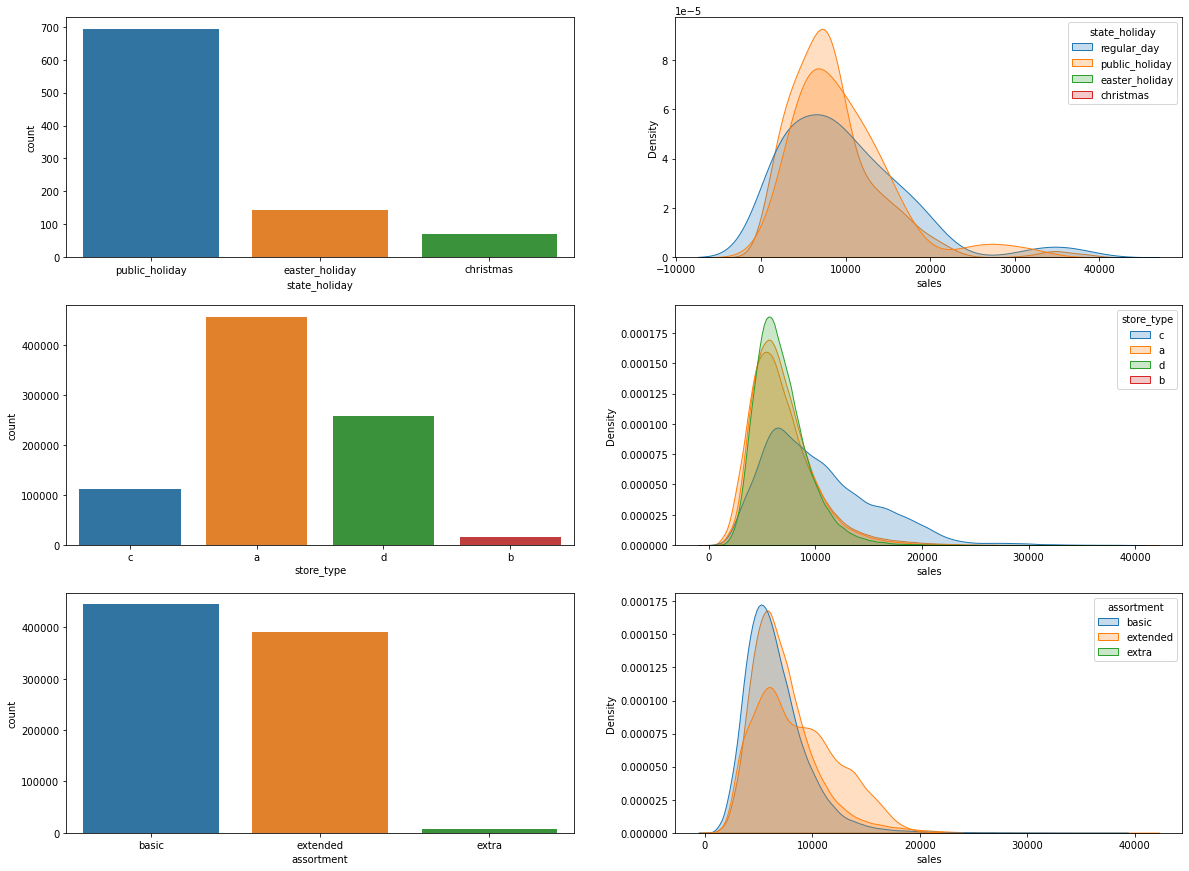

In [80]:
#state_holiday
f, ax = plt.subplots(figsize = (20, 15))
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', hue=df4['state_holiday'], shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', shade=True);


#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label="a", hue=df4['store_type'], shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label="b", shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label="c", shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label="d", shade=True)


#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], hue=df4['assortment'], shade=True);
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade=True);

## 4.2 Análise Bivariada

### **H1** Lojas com maior número de funcionários deveriam vender mais.
**FALSA** Lojas com maior sortimento vendem menos.

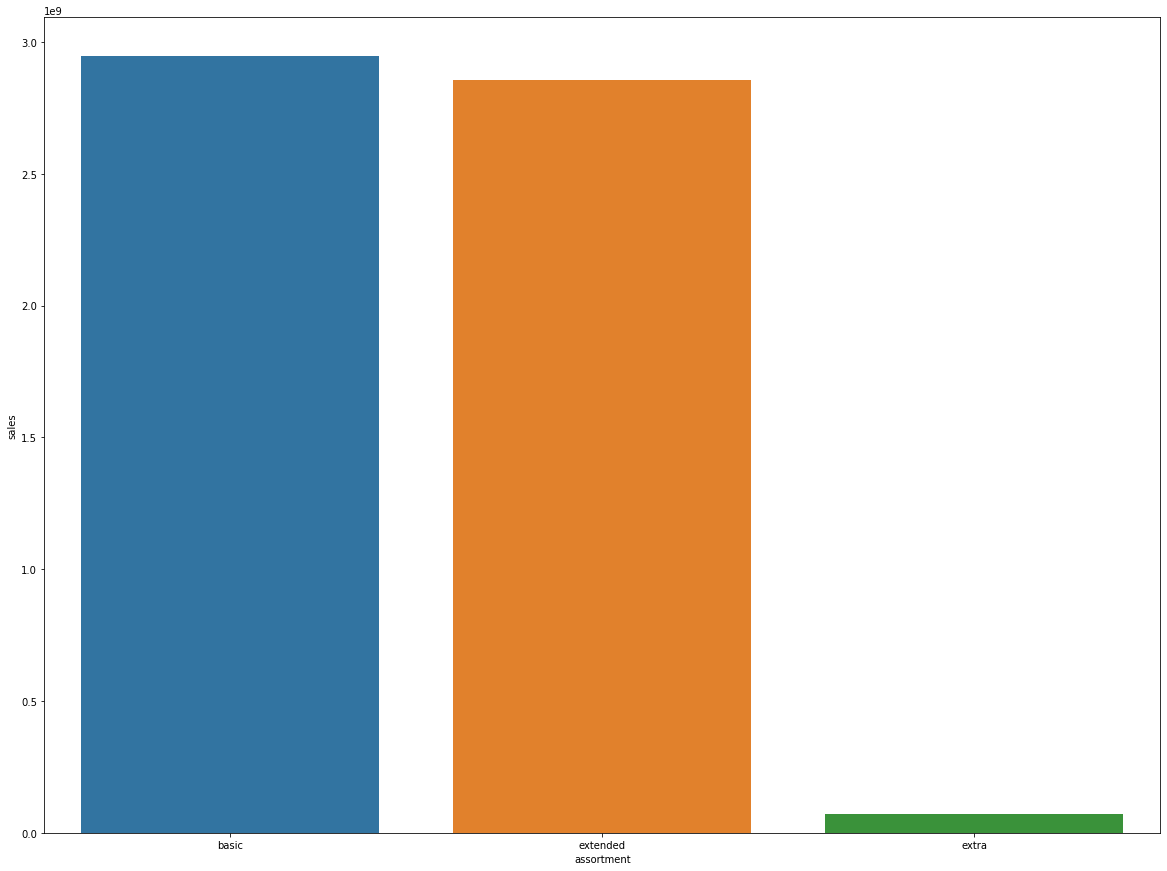

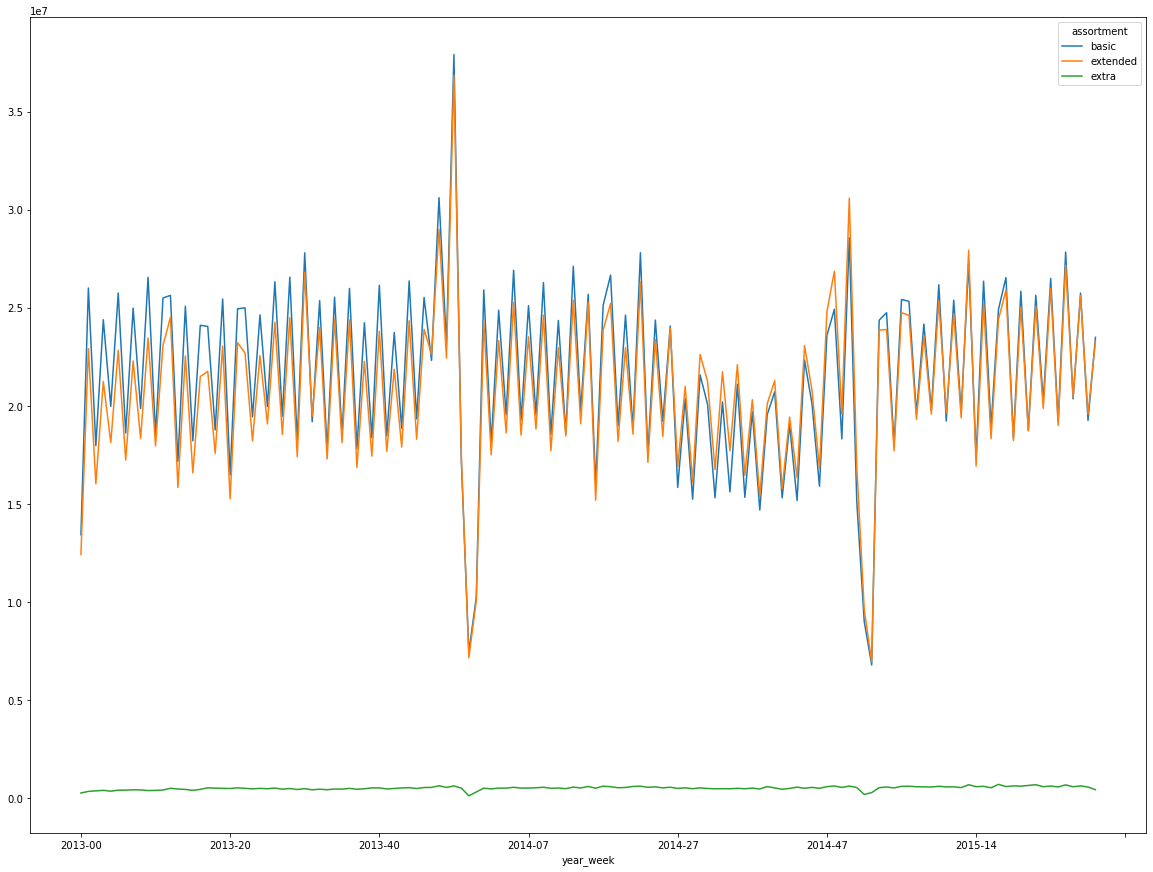

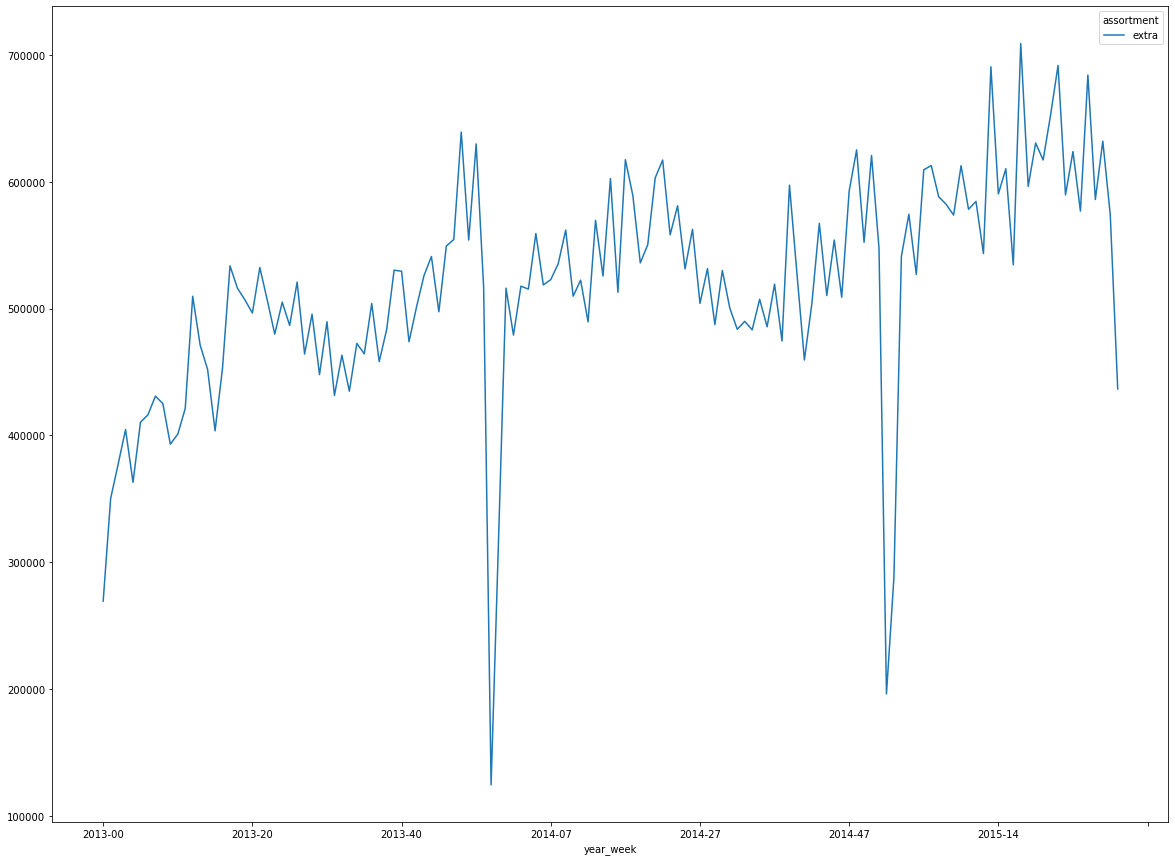

In [81]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

fig, ax = plt.subplots(figsize=(20,15))
sns.barplot(x='assortment', y='sales', data=aux1);


aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(20,15));

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(20,15));

### **H2** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com competidores mais próximos vendem mais

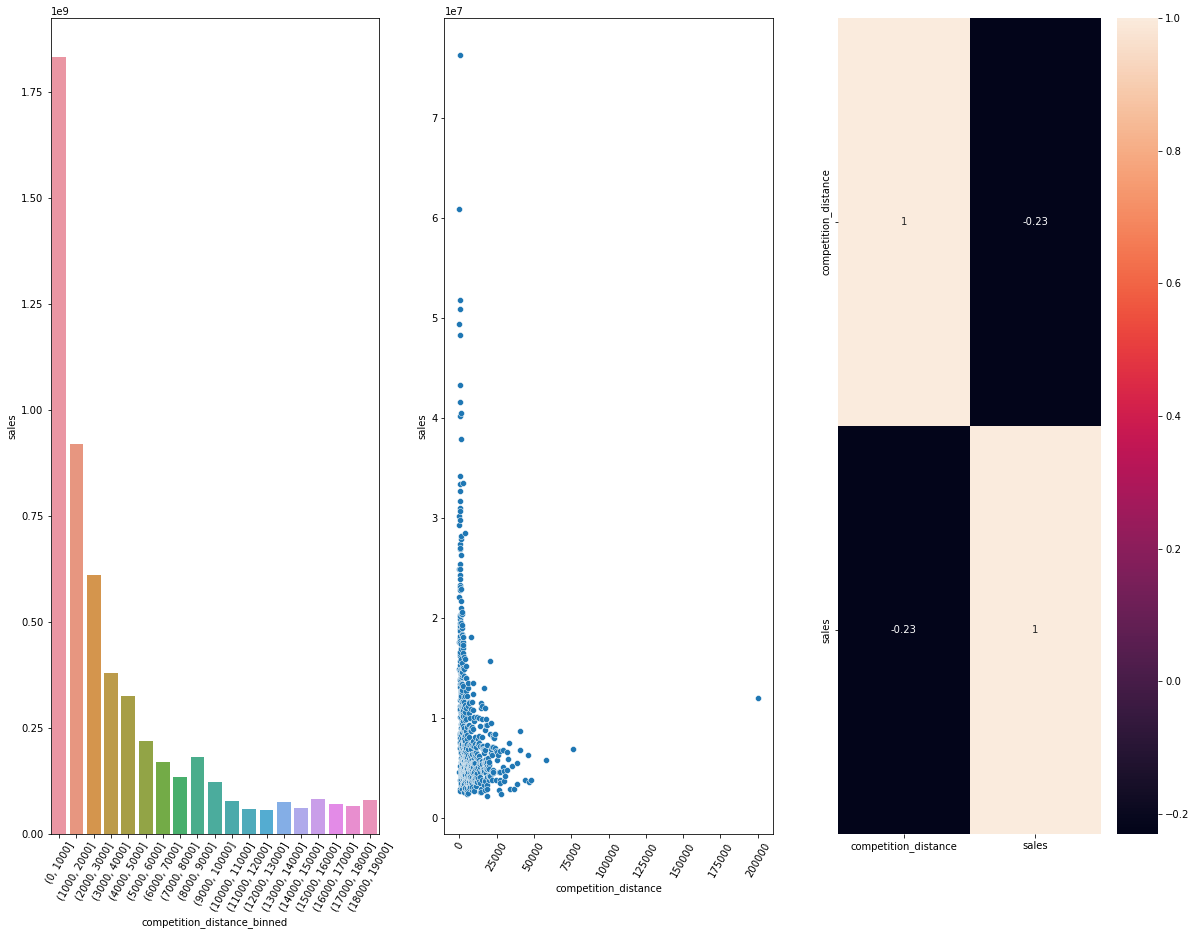

In [82]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

## Gráfico de barras
fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(1,3,1)
plt.xticks(rotation=60)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);

## Gráfico de pontos (scatter)
plt.subplot(1,3,2)
plt.xticks(rotation=60)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

## Mapa de calor
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3** Lojas com competidores a mais tempo deveriam vender mais.
**FALSA** Lojas com competidores a mais tempo vendem menos

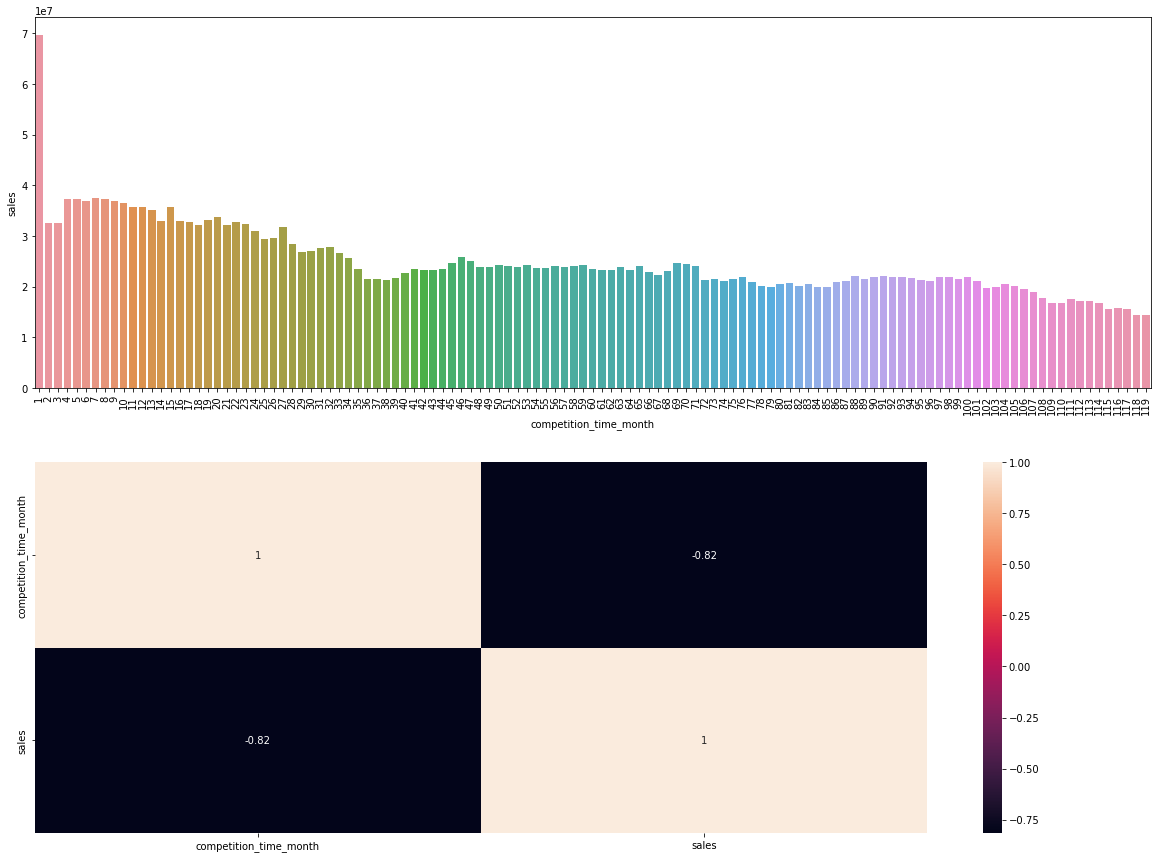

In [83]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] > 0)]

fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(2, 1, 1)
plt.xticks(rotation=90)
sns.barplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(2, 1, 2)
sns.heatmap(aux2.corr('pearson'), annot=True);

### **H4** Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSA** Lojas com mpromoções ativas por mais tempo vendem menos

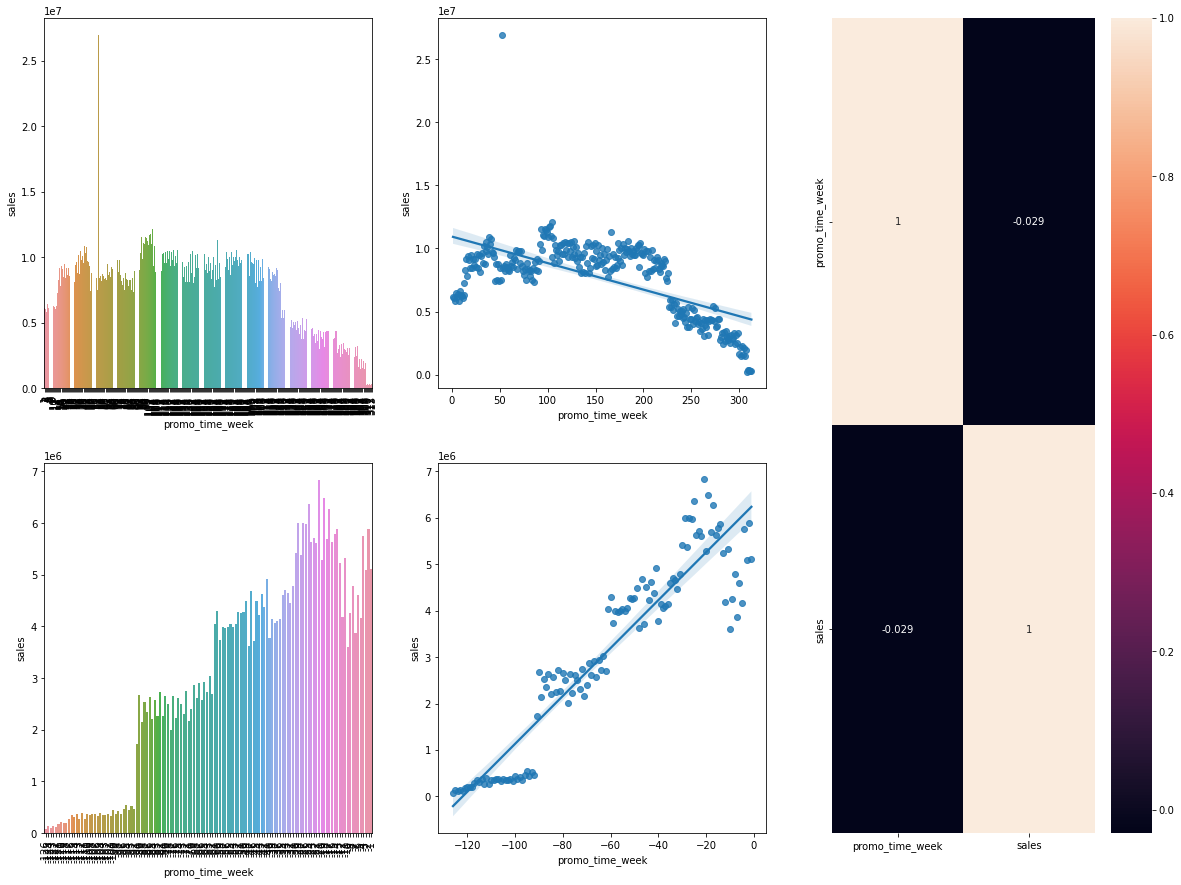

In [84]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2, 3)

## Separação em períodos
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido

fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(grid[0,0])
plt.xticks(rotation=90);
sns.barplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2); # Verifica a tendência da variável


aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
plt.subplot(grid[1,0])
plt.xticks(rotation=90);
sns.barplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3); # Verifica a tendência da variável

# Mapa de calor
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr('pearson'), annot=True);

## É possível observar com os gráficos abaixo que em uma promoção, as vendas têm um volume maior até certo período após o início
## Além disso, promoções futuras resulta em um aumento nas vendas quando o período de início da promoção está próximo.

### <s> **H5** Lojas com mais dias de promoção deveriam vender mais </s>

Devido a similaridade com a hipótese 4, será respondida no próximo ciclo do CRISP.

### **H6** Lojas com mais promoções consecutivas deveriam vender mais
**FALSA** Lojas com mais promoções consecutivas vendem menos.

In [85]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


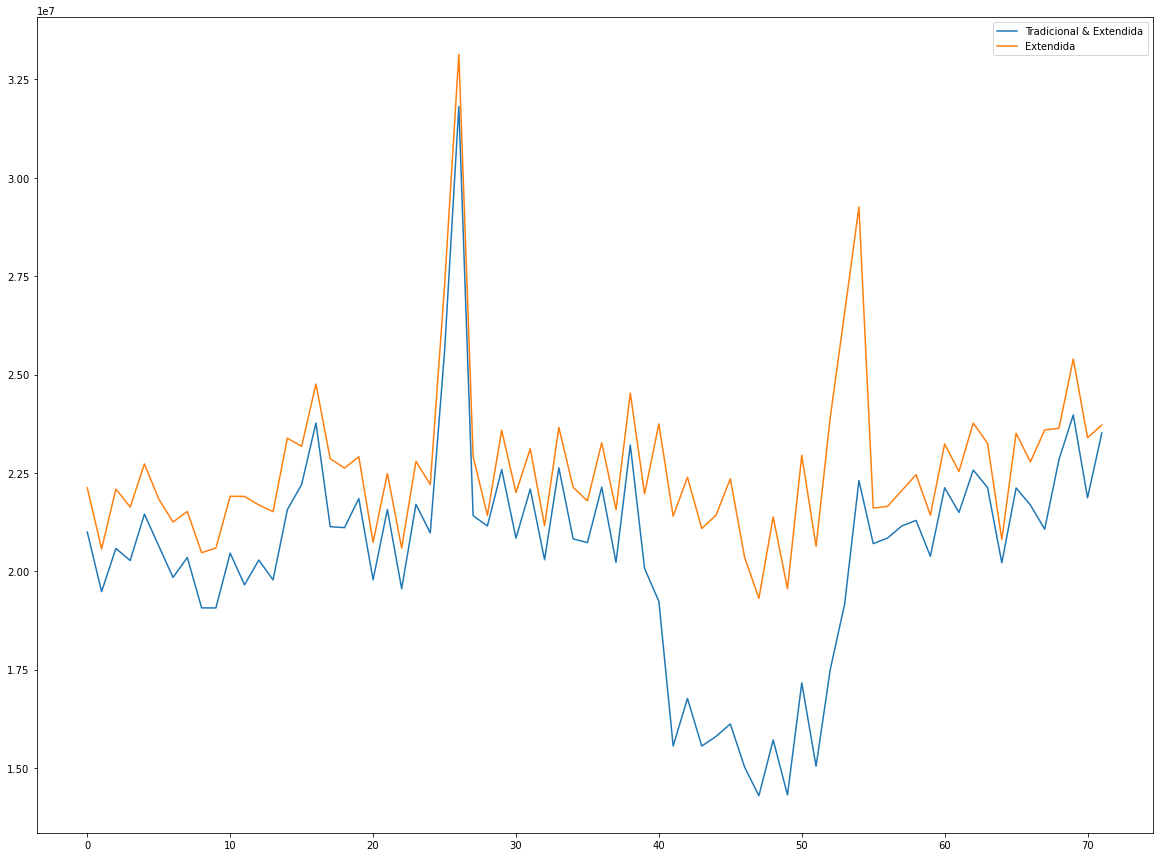

In [86]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
fig, ax = plt.subplots(figsize=(20,15))
aux1.plot(ax=ax)

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida'])

### **H7** Lojas abertas durante o feriado de Natal deveriam vender mais
**FALSA** Lojas abertas no Natal vendem menos

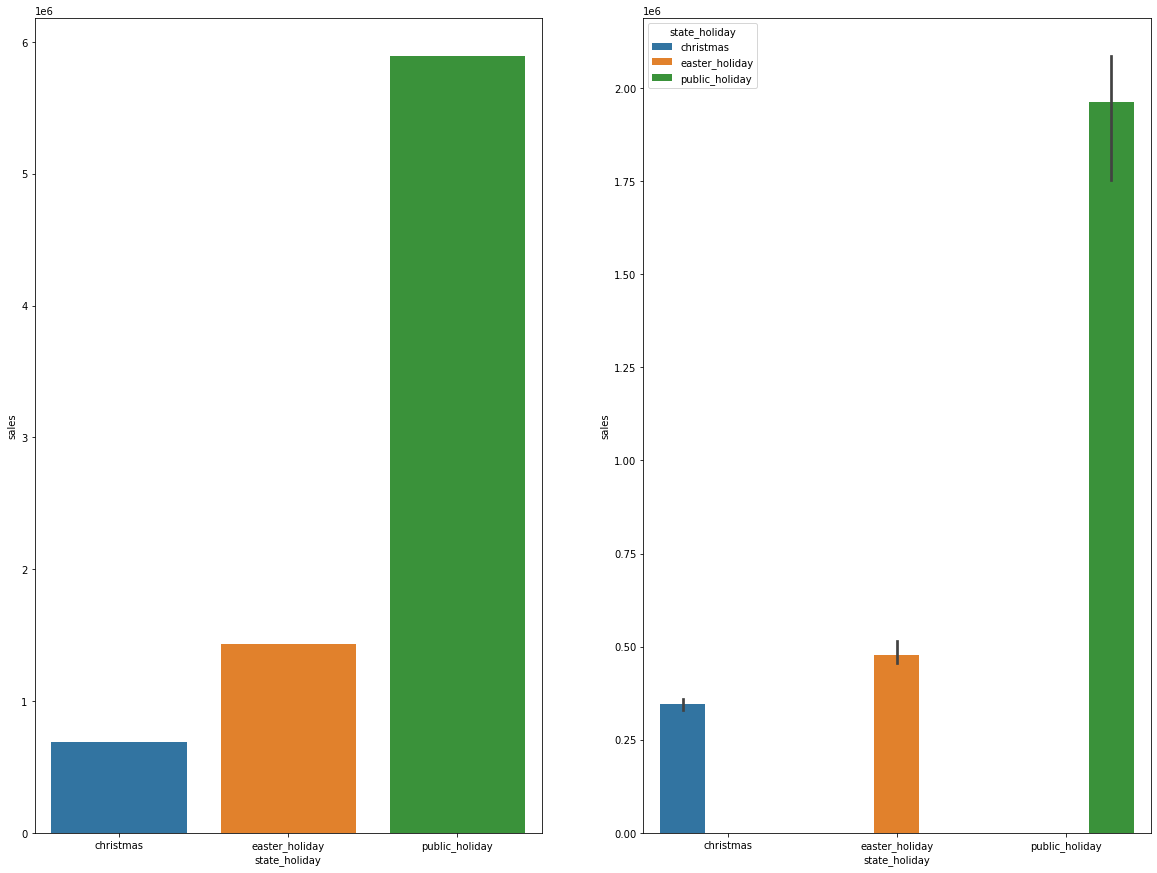

In [87]:
aux = df4[df4['state_holiday'] != 'regular_day']

fig, ax = plt.subplots(figsize=(20,15))

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);


plt.subplot(1,2,2)
aux2 = aux[['state_holiday', 'year', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='state_holiday', y='sales', hue='state_holiday', data=aux2);

### **H8** Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem menos ao longo dos anos

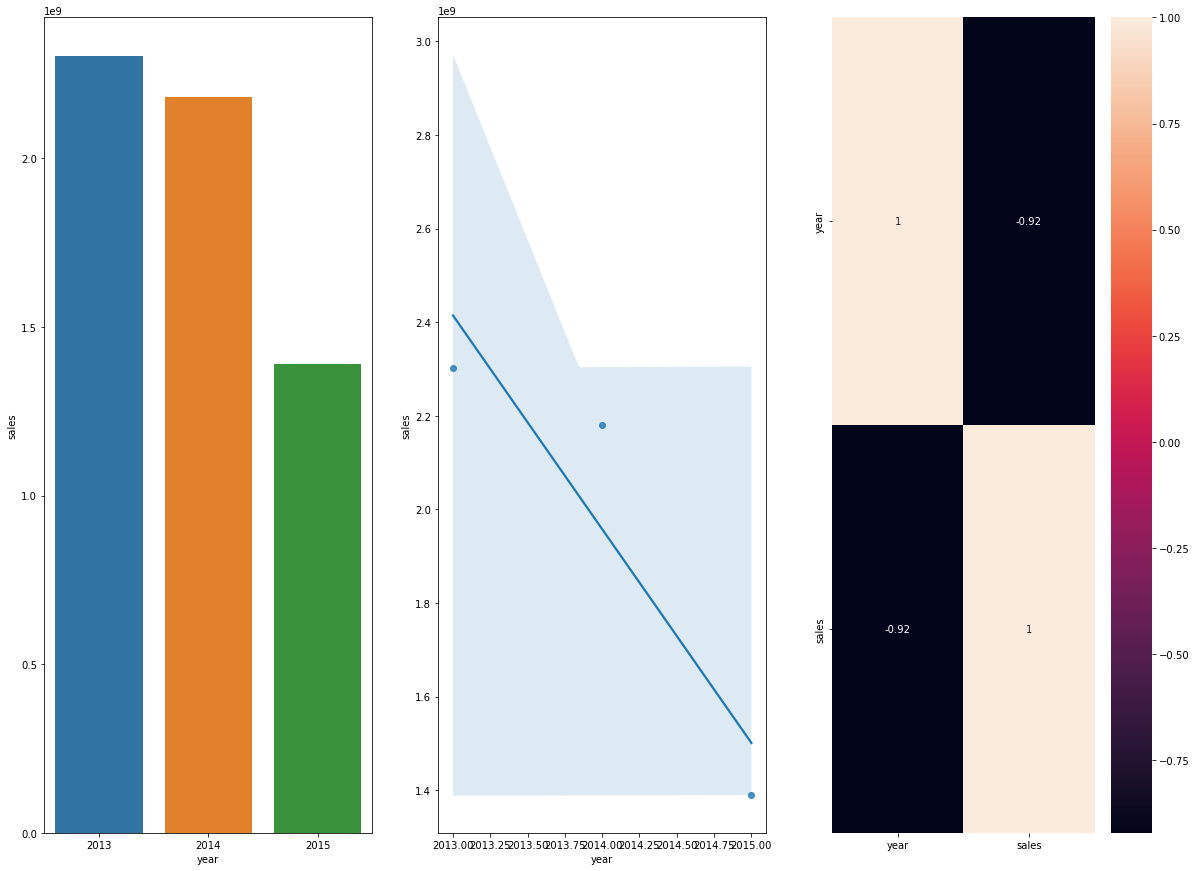

In [88]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr('pearson'), annot=True);

### **H9** Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem menos no segundo semestre do ano

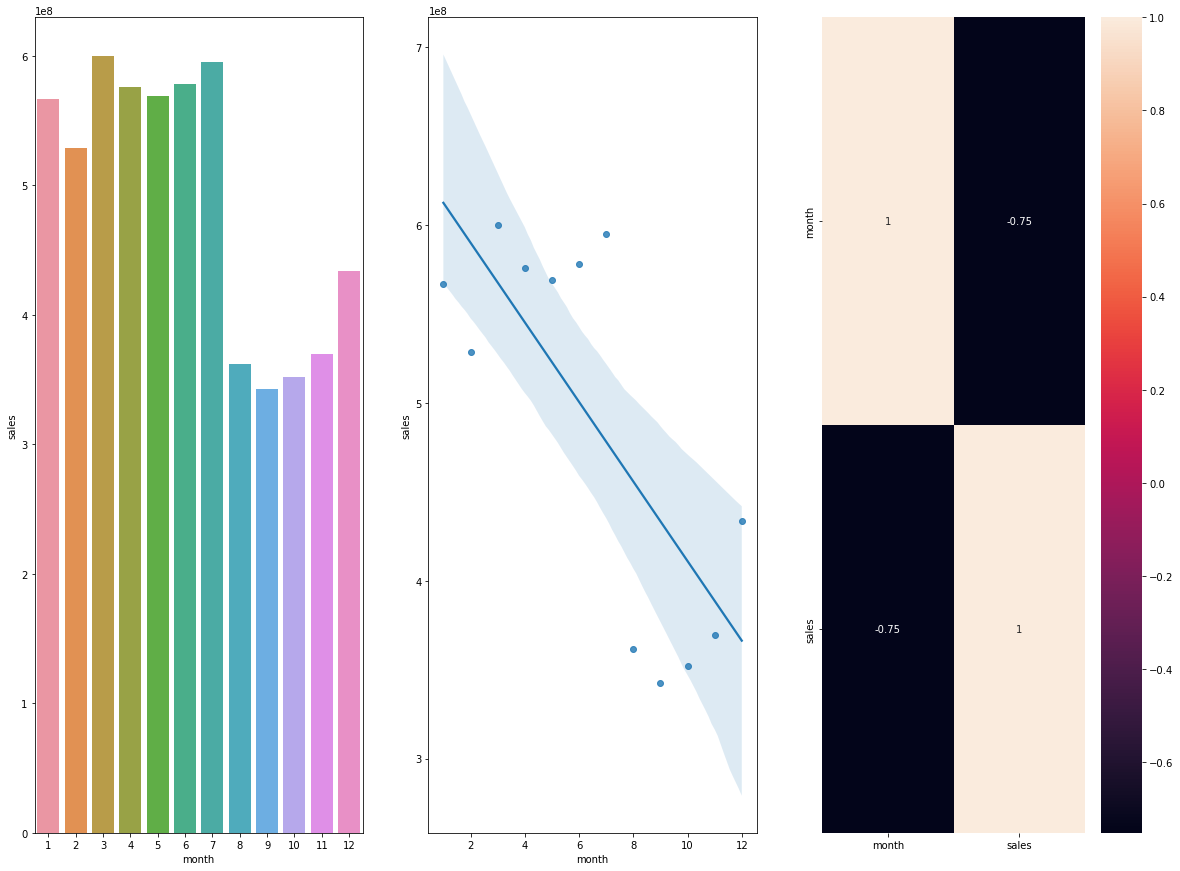

In [89]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr('pearson'), annot=True);

### **H10** Lojas deveriam vender mais depois do dia 10 de cada mês
**VERDADEIRO**

In [90]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10th_day' if x < 10 else 'after_10th_day')

aux1.head(15)

,day,sales,before_after
0,1,155983560,before_10th_day
1,2,233513169,before_10th_day
2,3,194582812,before_10th_day
3,4,228301010,before_10th_day
4,5,212869176,before_10th_day
5,6,197094539,before_10th_day
6,7,201380487,before_10th_day
7,8,189718770,before_10th_day
8,9,175922427,before_10th_day
9,10,181039363,after_10th_day


In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr('pearson'), annot=True);

plt.subplot(2,2,4)
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11** Lojas deveriam vender menos aos finais de semana
**VERDADEIRO**

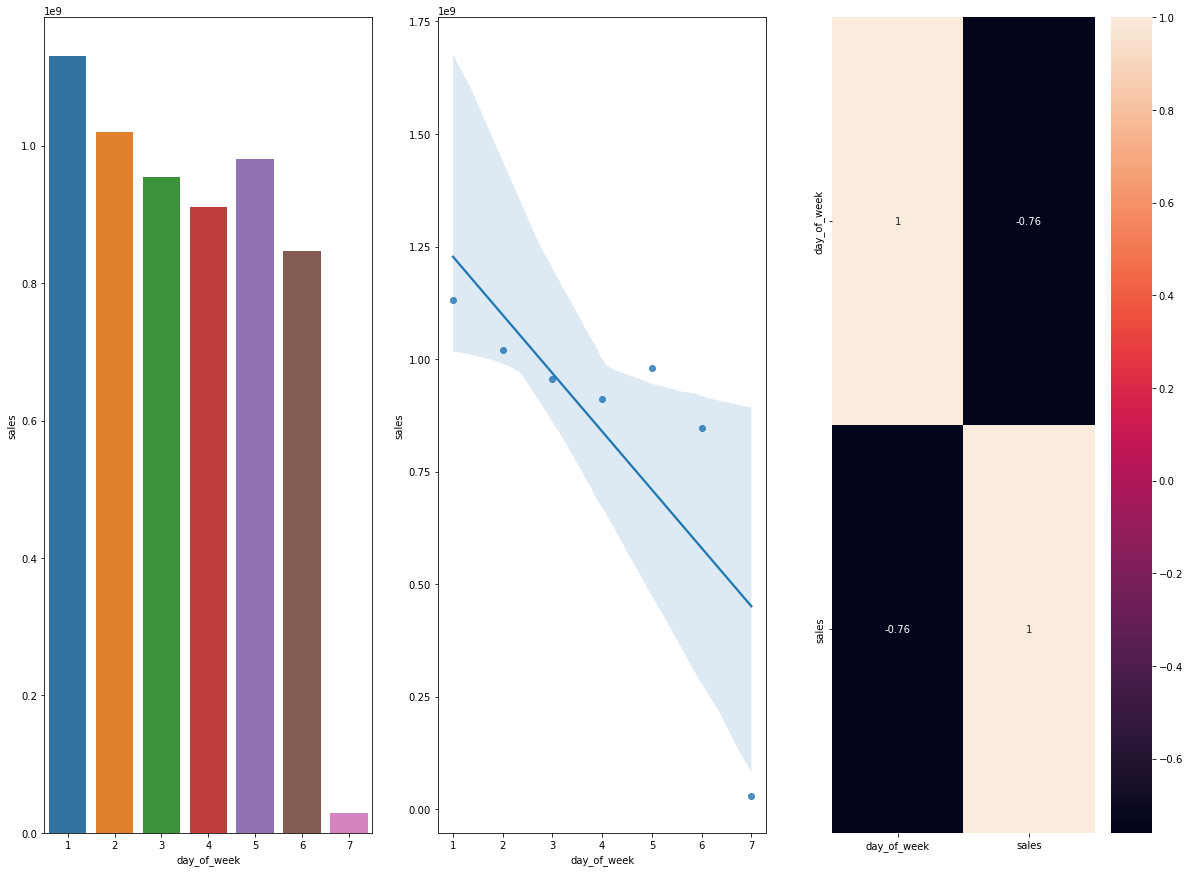

In [91]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr('pearson'), annot=True);

### **H12** Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRO** Exceto para o mês de agosto.

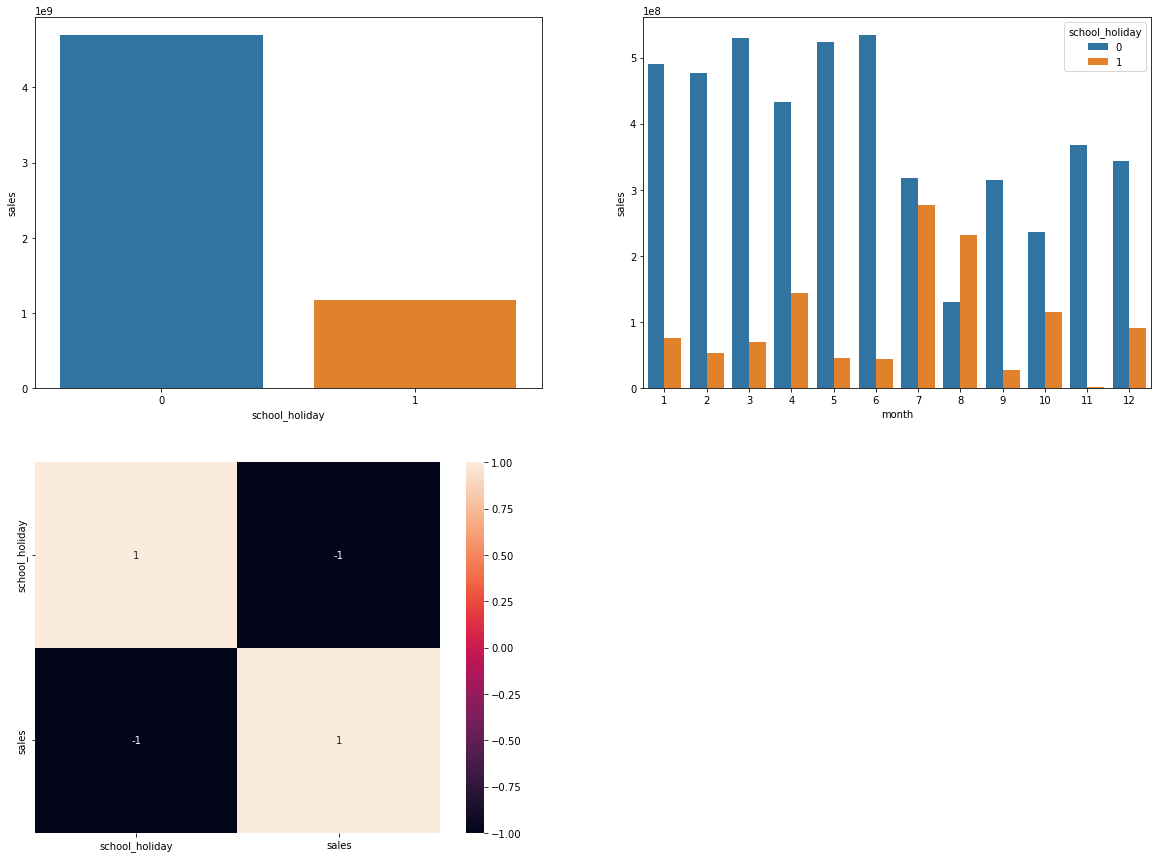

In [92]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(2,2,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);


aux2 = df4[['school_holiday', 'month', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,2,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr('pearson'), annot=True);

### 4.2.1 Resumo das Hipóteses

In [93]:
tab = [['Hipótese', 'Conclusão', 'Relevância'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Média'],
      ['H3', 'Falsa', 'Média'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Média'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa']]

print(tabulate(tab, headers='firstrow'))

Hipótese    Conclusão    Relevância
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Média
H3          Falsa        Média
H4          Falsa        Baixa
H5          -            -
H6          Falsa        Baixa
H7          Falsa        Média
H8          Falsa        Alta
H9          Falsa        Alta
H10         Verdadeira   Alta
H11         Verdadeira   Alta
H12         Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

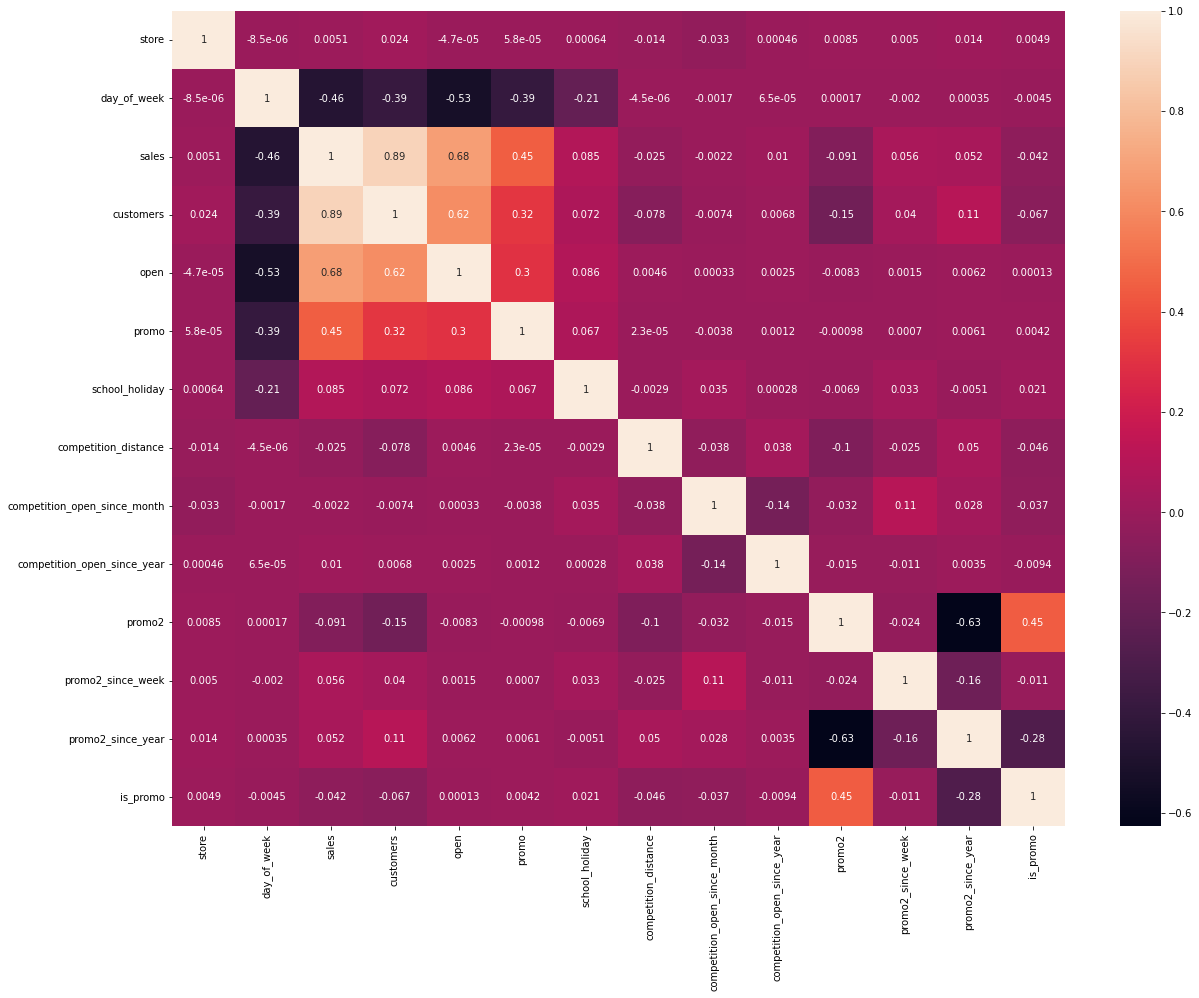

In [94]:
correlation = num_attributes.corr(method='pearson')

fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

In [95]:
# Only categorical data
a = df4.select_dtypes(include='object')

# Calculate Cramer V
a1 = crammer_v(a['state_holiday'], a['state_holiday'])
a2 = crammer_v(a['state_holiday'], a['store_type'])
a3 = crammer_v(a['state_holiday'], a['assortment'])

a4 = crammer_v(a['store_type'], a['state_holiday'])
a5 = crammer_v(a['store_type'], a['store_type'])
a6 = crammer_v(a['store_type'], a['assortment'])

a7 = crammer_v(a['assortment'], a['state_holiday'])
a8 = crammer_v(a['assortment'], a['store_type'])
a9 = crammer_v(a['assortment'], a['assortment'])


# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
             'store_type': [a4, a5, a6],
             'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

In [ ]:
sns.heatmap(d, annot=True);